In [1]:
import os

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# User input

In [2]:
# River numbers of interest
# Scenarios generated for model rivs 7-26 (incl.), but add the 2
# Swedish ones here. Also add rivs 27-29, which are in the OF800 domain??
oslofjord_model_riv_nos = list(range(5, 30))  # Model river numbers
out_folder_csvs = r"../output/csvs"

# Read in mappings

In [3]:
# Mapping from model river number to real river number (index: model riv no, returns real no)
setup_fpath = r'/home/jovyan/shared/common/oslofjord_modelling/oslofjord_location_ids.csv'
river_nos_s = pd.read_csv(setup_fpath, index_col=0).squeeze('columns')
river_nos_s.head()

model_river
1    1
2    1
3    2
4    3
5    4
Name: real_river, dtype: int64

In [4]:
# Mapping real river to vassdragsområde

# Work out corresponding real river numbers
min_val = min(oslofjord_model_riv_nos)
max_val = max(oslofjord_model_riv_nos)
oslofjord_real_riv_nos = river_nos_s.loc[min_val:max_val].tolist()
# Drop non-unique
oslofjord_real_riv_nos = list(set(oslofjord_real_riv_nos))
print(oslofjord_real_riv_nos)

real_riv_metadata = r"../data/real_river_metadata.csv"
river_meta_df = pd.read_csv(real_riv_metadata, index_col=0, dtype={'Vassom':str})

# Limit to just Oslofjord rivers
river_meta_df = river_meta_df[river_meta_df.index.isin(oslofjord_real_riv_nos)]

# Fill NaNs in the Vassdragsområde columns with 'Sweden'
river_meta_df.loc[river_meta_df.index < 6, 'Vassom'] = river_meta_df.loc[river_meta_df.index < 6, 'Vassom'].fillna('Sweden')

river_meta_df

[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23]


,river_name,Outflow_lat,Outflow_lon,Regine,Regine_to_sea,Vassom,Vassom_area_land,Vassom_area_tot,Andre_MCA_area,Andre_area_q,Overestimate (%),Comment
real_river,,,,,,,,,,,,
4,Strömsån,NaN,NaN,NaN,NaN,Sweden,NaN,NaN,NaN,NaN,NaN,NaN
5,Enningdalsälv,NaN,NaN,NaN,NaN,Sweden,NaN,NaN,NaN,NaN,NaN,NaN
6,Tista,59.119,11.370,001.A1,001.A1,001.,2495.0,2507.0,2507.0,1584.0,0.0,NaN
7,Glomma,59.206,10.953,002.A51,002.A11,002.,42446.0,43116.0,43116.0,41967.0,2.0,Monitoring point upstream of Sarpsborg RA. So ...
8,Mosseelva,59.439,10.662,003.A1,003.A1,003.,854.0,1052.0,1054.0,694.0,23.0,NaN
9,Hølenelva,59.523,10.690,004.A0,004.A0,004.,204.0,227.0,NaN,NaN,11.0,NaN
10,Årungen,59.720,10.728,005.3A,005.3A,005.,280.0,368.0,144.0,85.0,31.0,NaN
11,Akerselva,59.908,10.756,006.A10,006.A10,006.,392.0,415.0,415.0,307.0,6.0,NaN
12,Lysakerelva,59.914,10.640,007.A0,007.A0,007.,202.0,211.0,211.0,177.0,4.0,NaN


In [5]:
# Mapping from real river number to river name
river_names_fpath = r'/home/jovyan/shared/common/oslofjord_modelling/MARTINI800v10_river_inputs/river_names.csv'
river_names_s = pd.read_csv(river_names_fpath, index_col=0).squeeze('columns')
river_names_s.head()

real_river
1         Göta älv
2           Bäveån
3     Örekilsälven
4         Strömsån
5    Enningdalsälv
Name: river_name, dtype: object

In [6]:
# Vassdragsområde to real river
nog_river_meta_df = river_meta_df[river_meta_df['Vassom'].notna()].copy()
vass_to_realriv_dict = nog_river_meta_df.reset_index().set_index('Vassom')['real_river'].to_dict()
vass_to_realriv_dict

{'Sweden': 5,
 '001.': 6,
 '002.': 7,
 '003.': 8,
 '004.': 9,
 '005.': 10,
 '006.': 11,
 '007.': 12,
 '008.': 13,
 '009.': 14,
 '010.': 15,
 '011.': 17,
 '012.': 18,
 '013.': 19,
 '014.': 20,
 '015.': 21,
 '016.': 22,
 '017.': 23}

In [7]:
wwtp_isource_map_fpath = r'/home/jovyan/shared/common/oslofjord_modelling/MARTINI800v10_river_inputs/Flux_Martini_Rivers_sewage_with_mapping_and_fractions.xlsx'
isource_vassom_map_df = pd.read_excel(wwtp_isource_map_fpath, sheet_name='vassområde_link', index_col=0)
# Reformat vassdragsområde integer to match string format used elsewhere
isource_vassom_map_df['Vassdragsområde'] = isource_vassom_map_df['Vassdragsområde'].apply(lambda x: (str(x)).zfill(3) + '.')
isource_vassom_map_df

,Vassdragsområde,Comment
iSource,,
1,003.,NaN
2,003.,NaN
3,003.,NaN
4,004.,NaN
5,005.,NaN
6,006.,NaN
7,009.,VEAS main outlet
23,007.,VEAS overflow outlet. TEOTIL probably thinks t...
8,011.,NaN


# Read in and process river netcdf files

## Define functions

In [8]:
def riv_ds_to_df(nc_fpath, oslofjord_model_riv_nos):
    """
    Read in OF800 river input netcdf file. Convert to dataframe of concentrations
    & river discharge for real rivers.
    N.B. Only works for N species, has some hard-coding
    """

    riv_var_li = ["river_transport", "river_N3_n", "river_N4_n",
                  "river_R123_n", "river_R4_n", "river_R6_n", "river_R8_n"]
    riv_chem_var_li = [item for item in riv_var_li if item != 'river_transport']

    ds = xr.open_dataset(nc_fpath)
    ds = ds[riv_var_li]
    df = ds.to_dataframe()
    ds.close()
    df = df.reset_index()  # Drop multiindex

    # Remove depth info
    if 's_rho' in df.columns:
        df = df.drop(columns=['s_rho'])
        df = df.drop_duplicates()  # There were around 40 s_rho values for each (river_time, river)

    df = df.sort_values(by=['river', 'river_time'])

    # Take the absolute of discharge values (assume they give direction)
    df['river_transport'] = df['river_transport'].abs()

    df = df.reset_index(drop=True)

    # Select just model river numbers of interest
    df = df[df['river'].isin(oslofjord_model_riv_nos)]

    # Add real river number & drop the model number
    df['river_no'] = df['river'].map(river_nos_s)
    # df = df.drop(columns=['river'])

    # Truncate to time period of interest
    df['year'] = df['river_time'].dt.year
    df = df.loc[(df['year'] >= start_year) & (df['year'] <= end_year)]
    df = df.drop('year', axis=1)

    # Calculate Total N & DIN, and drop the other N fractions
    df['TOTN'] = df[riv_chem_var_li].sum(axis=1)
    df['DIN'] = df['river_N3_n'] + df['river_N4_n']
    # N.B. ignoring the 1% of TPN that Phil adds as PIN
    # Drop all the fractions apart from TOTN and DIN 
    df = df.drop(riv_chem_var_li, axis=1)

    # Sum over model rivers to get real river data

    # Check if all discharge values in each group are the same. If not, will have to
    # flow-weight the concentrations when calculating means
    is_constant = df.groupby(['river_no', 'river_time'])['river_transport'].nunique() <= 1
    if not is_constant.all():
        print(f"Discharge values are not the same for all real river model groupings")
    else:
        print("Discharge values constant between model river groups")

    # For QC. Manually checked the summing & averaging working ok. It is.
    # print(df.loc[(df['river_no'] == 7) & (df['river_time'] == '2016-01-01 12:00')])

    # Sum discharge
    conc_df = df.groupby(['river_no', 'river_time']).agg({'river_transport': 'sum'})

    # Mean of all other columns within each river
    mean_df = df.groupby(['river_no', 'river_time'])[['TOTN', 'DIN']].mean()

    # Join the sums and means to one df
    conc_df = pd.concat([conc_df, mean_df], axis=1)
    conc_df = conc_df.reset_index()

    # Convert concentration units from mMoles/m3 to mg/l
    # N.B. HARDCODED, needs generalising for diff vars & units
    Mr_N = 14.0067
    for col in ['TOTN', 'DIN']:
        conc_df[col] = conc_df[col] * Mr_N * 0.001

    # Rename cols
    # Warning: HARDCODED, needs generalising for diff vars
    new_col_names = ['real_river', 'date', 'Q', 'TOTN', 'DIN']
    conc_df = conc_df.set_axis(new_col_names, axis=1)

    return conc_df


def calc_daily_flux(conc_df, out_folder, run_type):
    """ Units kg/day
    """
    load_df = conc_df[['real_river', 'date']].copy()
    # Ensure the 'date' column is in datetime format
    load_df['date'] = pd.to_datetime(load_df['date'])
    load_df['Q'] = conc_df['Q'] * 86400  # from m3/s to m3/day

    for var in ['TOTN', 'DIN']:
        # Load in kg/day
        chem_kgperm3 = conc_df[var] * 1000 * 10**-6
        load_df[var] = load_df['Q'] * chem_kgperm3

    # To csv
    fpath = os.path.join(out_folder, f'daily_river_fluxes_{start_year}-{end_year}_{run_type}.csv')
    load_df.to_csv(fpath)

    return load_df


def calc_month_annual_flux(daily_load_df, freq, out_folder, run_type):
    """
    Input:
        freq: 'monthly' for monthly, 'annual' for annual
        run_type: string, for file naming. E.g. 'baseline'
    Output: df, units Q: 10^6 m3/month or year; N: T/month or year
    """
    freq_dict = {'monthly': 'ME',
                 'annual': 'YE'}

    # daily_load_df.set_index(['real_river', 'date'], inplace=True)
    agg_load_df = daily_load_df.set_index(['real_river', 'date']).groupby('real_river').resample(freq_dict[freq], level='date').sum()
    agg_load_df.reset_index(inplace=True)

    # Convert units: N species from kg to 10^3 kg/month (T/month)
    for var in ['TOTN', 'DIN']:
        agg_load_df[var] = agg_load_df[var] / 10**3

    # Convert Q from m3/month to 10^6 m3/month
    agg_load_df['Q'] = agg_load_df['Q'] / 10**6

    if freq == 'annual':
        agg_load_df['year'] = pd.to_datetime(agg_load_df['date']).dt.year
        agg_load_df = agg_load_df.drop('date', axis=1)

    # Write to csv
    fpath = os.path.join(out_folder, f'{freq}_river_fluxes_{start_year}-{end_year}_{run_type}.csv')
    agg_load_df.to_csv(fpath)

    return agg_load_df


def mean_annual_flux(annual_load_df, out_folder, run_type):
    """
    Average over years to get overall mean annual flux per real river
    Inputs start_year, end_year, run_type: format string, for filenaming
    Output: df, index: real_river, cols: Q (10^6 m3/yr), TOTN and DIN (T/yr)
    """
    yr_mean_df = annual_load_df[['Q', 'TOTN', 'DIN', 'real_river']].groupby('real_river').mean()

    # Write to csv
    fpath = os.path.join(out_folder, f'mean_annual_riv_flux_{start_year}-{end_year}_{run_type}.csv')
    yr_mean_df.to_csv(fpath)

    return yr_mean_df

## Processing

In [9]:
# Setup
start_year = 2016
end_year = 2022

nc_folder = r'/home/jovyan/shared/common/oslofjord_modelling/MARTINI800v10_river_inputs/of800_input_files/'
flux_folder = r'../output/csvs/of800_fluxes'

nc_fname_dict = {'baseline': 'of800_rivers_v9_1990_2022_RA1_baseline.nc',
                 'remove_summer_din': 'of800_rivers_v9_1990_2022_RA1_SummerDINsources100pcred.nc',
                 'realistic': 'of800_rivers_v9_2013_2022_RA1_DINredRA80-J10_v1.nc'
                }

monthly_rivflux_dict = {}
annual_rivflux_dict = {}
mean_annual_rivflux_dict = {}

# Process
for scenario in nc_fname_dict.keys():

    print(scenario)

    nc_fpath = os.path.join(nc_folder, nc_fname_dict[scenario])
    conc_df = riv_ds_to_df(nc_fpath, oslofjord_model_riv_nos)

    daily_load_df = calc_daily_flux(conc_df, flux_folder, scenario)
    monthly_load_df = calc_month_annual_flux(daily_load_df, 'monthly', flux_folder, scenario)
    annual_load_df = calc_month_annual_flux(daily_load_df, 'annual', flux_folder, scenario)
    mean_annual_load_df = mean_annual_flux(annual_load_df, flux_folder, scenario)

    # Add to dictionaries
    monthly_rivflux_dict[scenario] = monthly_load_df
    annual_rivflux_dict[scenario] = annual_load_df
    mean_annual_rivflux_dict[scenario] = mean_annual_load_df

    print(annual_load_df.head())
    print(mean_annual_load_df)
    print('\n')

baseline
Discharge values are not the same for all real river model groupings
   real_river          Q       TOTN        DIN  year
0           4  18.174750  15.763338   7.265982  2016
1           4  27.655560  27.664767  11.040932  2017
2           4  24.800291  23.632291  13.044011  2018
3           4  38.902239  39.705597  20.657497  2019
4           4  38.416559  35.903947  17.201529  2020
                       Q          TOTN          DIN
real_river                                         
4              27.160499     25.598652    12.096766
5             432.631306    357.558436   217.397229
6            1102.608883   1140.373981   700.417000
7           23312.929406  14445.507424  9783.242991
8             518.387832    590.910169   369.462893
9             107.983238    336.591913   227.354250
10             68.906739    219.472712   141.051115
11            194.250628     75.850757    40.315931
12            156.626973     81.260592    31.249415
13            175.262283    147.

# Read in direct sewage inputs

Calculate the total wastewater treatment plant N loads that are included in OF800 as direct inputs to the fjord. This is implemented either by adding loads to the model river fluxes (PWA does this as a post-processing step) or adding loads directly to the fjord (the iSources netcdf file).

In [10]:
def isource_to_df(wwtp_fpath):
    """
    Input: filepath to ERSEN internal sources netcdf
    Output: Dataframe of monthly fluxes (units T/month)
    Read in ERSEM internal source netcdf.
    Only keep N data, convert units to mg/l, drop depth info,
    calculate total N and DIN, save as dataframe
    """

    # Molecular weight of N (g/mole)
    Mr_N = 14.0067

    # WWTP direct inputs
    wwtp_ds = xr.open_dataset(wwtp_fpath)

    # Sum over the 's_rho' dimension
    wwtp_ds = wwtp_ds.sum(dim='s_rho')

    wwtp_df = wwtp_ds.to_dataframe()
    wwtp_df = wwtp_df.reset_index()  # Drop multiindex
    wwtp_ds.close()

    # Drop all WWTPs which are outside oslofjord
    # wwtp_df = wwtp_df[wwtp_df['isource'].isin(isource_oslofjord_ids)]

    wwtp_df['isource_time'] = pd.to_datetime(wwtp_df['isource_time'])
    wwtp_df = wwtp_df.rename(columns={'isource_time': 'date'})

    print('Number of WWTPs: %s ' % len(wwtp_df['isource'].drop_duplicates()))

    # Drop all columns which are not N fluxes
    cols_to_keep = ['isource', 'date'] + [col for col in wwtp_df.columns if col.endswith('_n')]
    wwtp_df = wwtp_df[cols_to_keep]

    # Calculate TOTN
    cols_to_exclude = ['isource', 'date']
    cols_to_sum = [col for col in cols_to_keep if col not in cols_to_exclude]

    # Create a new column 'sum' that is the sum of all columns in cols_to_sum
    wwtp_df['TOTN'] = wwtp_df[cols_to_sum].sum(axis=1)
    wwtp_df['DIN'] = wwtp_df['isource_N3_n'] + wwtp_df['isource_N4_n']

    wwtp_chem_vars = ['TOTN', 'DIN']

    # Drop all the subfractions apart from TOTN and DIN
    wwtp_df = wwtp_df.drop(cols_to_sum, axis=1)

    # Convert units from mmol/s to 10^3 kg/month (tonnes/month)
    # NB NEEDS IMPROVING, not accurate now, uses average number of days/month
    # instead of actual number of days/month
    for var in ['TOTN', 'DIN']:
        wwtp_df[var] = wwtp_df[var] * Mr_N * 86400 * 30.417 * 10**-9

    return wwtp_df


def calculate_average_annual_sum(monthly_df, start_year, end_year):
    """
    Input: df with columns 'isource' and 'date', plus data
    Output: Fluxes of TOTN, DIN. Units T/yr
    """
    # Pick out years within the user-specified range
    df = monthly_df.copy()
    df['year'] = df['date'].dt.year
    df = df[(df['year'] >= start_year) & (df['year'] <= end_year)].copy()

    # Calculate annual sums for all the remaining years
    df = df[['TOTN', 'DIN', 'isource', 'year']].groupby(['isource', 'year']).sum().reset_index()

    # Average the annual sums to get a single value per isource
    df = df.groupby('isource').mean()

    # Drop 'year' column
    df = df[['TOTN', 'DIN']]

    return df


def sum_over_vassom(input_df, time_col=[]):
    """
    Sum up multiple iSource inputs per vassdragsområde
    Input:
        input_df: dataframe, column or index=iSource id
        time_col: list of column names in input_df to base grouping on. E.g.
                  ['date']
    Output: dataframe, index=Vassdragsområde (format '00x.') if time_col==[], 
            otherwise, same cols as input df
            Units: T/yr
    """
    df = input_df.copy()

    # Add Vassdragsområde to the dataframe
    if 'isource' in df.columns:
        df['Vassom'] = df['isource'].map(isource_vassom_map_df['Vassdragsområde'])
    else:
        df['Vassom'] = df.index.map(isource_vassom_map_df['Vassdragsområde'])

    # Drop rows where Vassom == NaN (further SW than we are considering here)
    df = df.dropna(subset=['Vassom'])

    grouping_cols = ['Vassom'] + time_col
    df = df[grouping_cols + ['TOTN', 'DIN']].groupby(grouping_cols).sum()

    # If no time col, keep the index as Vassom. Otherwise, reset it
    if time_col != []:
        df = df.reset_index()

    return df


def read_wwtp_river_inputs(fpath, sheet):
    """
    Some of the WWTWs around Oslofjord are added to the river input file rather
    than as iSources. Read in those data here and sum them up over vassdragsområder
    Input: filepath to excel file and sheet name
    Output: dataframe, index: Vassdragsområde number (format '00x.'), fluxes in T/yr
    """
    wwtp_riv_df = pd.read_excel(fpath, sheet)
    wwtp_riv_df = wwtp_riv_df[['model_riv_id', 'TN_total_ton_yr', 'DIN_total_ton_yr']]

    # Map model river numbers to real river numbers
    wwtp_riv_df['real_riv_id'] = wwtp_riv_df['model_riv_id'].map(river_nos_s)

    # Add vassdragsområde
    wwtp_riv_df['Vassom'] = wwtp_riv_df['real_riv_id'].map(river_meta_df['Vassom'])

    # Sum up multiple inputs per Vassom
    wwtp_riv_df = wwtp_riv_df[['TN_total_ton_yr', 'DIN_total_ton_yr', 'Vassom']].groupby('Vassom').sum()

    # Match column names to isource dataframe
    wwtp_riv_df.columns = ['TOTN', 'DIN']

    return wwtp_riv_df


def total_annual_wwtw_inputs(isource_df, wwtp_riv_df, units='T'):
    """
    Sum direct WWTW inputs from the iSource file and inputs added to
    the river file to get total extra WWTW additions to Oslofjord
    Input: units can be 'T' or 'kg' per year
    """

    direct_wwtp_annual_df = wwtp_riv_df.add(isource_df, fill_value=0)

    # Also add in mapping to real_river, for compatibility with work below
    mapping_dict = river_meta_df.reset_index().set_index('Vassom')['real_river'].to_dict()
    direct_wwtp_annual_df['real_river'] = direct_wwtp_annual_df.index.map(mapping_dict)

    # Drop NaNs (Larvik in this case)
    direct_wwtp_annual_df = direct_wwtp_annual_df.dropna(how='any', axis=0)

    # Optionally convert units to kg
    if units == 'kg':
        direct_wwtp_annual_df[['TOTN', 'DIN']] = round((direct_wwtp_annual_df[['TOTN', 'DIN']] * 1000), 2)

    return direct_wwtp_annual_df

In [11]:
nc_isource_fname_dict = {'baseline': 'of800_v10b_isource_1990_2022_baseline.nc',
                         'remove_summer_din': 'of800_v10b_isource_1990_2022_SummerDINsources100pcred.nc',
                         'realistic': 'of800_v10b_isource_2013_2022_DINredRA80-J10_v1.nc'
                        }

isource_oslofjord_ids = list(range(1, 14)) + [23]  # Just directly inputting to Oslofjord

monthly_isource_dict = {}
mean_annual_isource_dict = {}

# Process
for scenario in nc_isource_fname_dict.keys():

    print(scenario)

    nc_fpath = os.path.join(nc_folder, nc_isource_fname_dict[scenario])
    wwtp_isource_df = isource_to_df(nc_fpath)
    isource_monthly_vassom_df = sum_over_vassom(wwtp_isource_df, ['date'])  #Cols Vassom, date, TOTN, DIN
    isource_av_yr_df = calculate_average_annual_sum(wwtp_isource_df, 2015, 2018)
    isource_av_yr_vassom_df = sum_over_vassom(isource_av_yr_df)

    # Add to dictionaries
    monthly_isource_dict[scenario] = isource_monthly_vassom_df
    mean_annual_isource_dict[scenario] = isource_av_yr_vassom_df

    print(isource_monthly_vassom_df.head())
    print(isource_av_yr_vassom_df)
    # print(wwtp_isource_df.head())
    # print(isource_av_yr_df)
    print('\n')

baseline
Number of WWTPs: 23 
  Vassom       date       TOTN        DIN
0   003. 1989-12-15  24.172932  21.726918
1   003. 1990-01-15  24.172932  21.726918
2   003. 1990-02-15  24.172932  21.726918
3   003. 1990-03-15  24.172932  21.726918
4   003. 1990-04-15  24.172932  21.726918
               TOTN          DIN
Vassom                          
003.     290.075179   260.723017
004.      56.661621    50.928138
005.      56.560620    49.157339
006.     394.914328   257.202619
007.      17.870696    13.744706
009.    1261.236272  1084.461435
011.      94.133032    84.607887
012.     294.822231   256.232628
013.     149.703841   134.555591
014.     294.040482   256.890798
015.     203.688932   183.078032


remove_summer_din
Number of WWTPs: 23 
  Vassom       date       TOTN        DIN
0   003. 1989-12-15  24.172932  21.726918
1   003. 1990-01-15  24.172932  21.726918
2   003. 1990-02-15  24.172932  21.726918
3   003. 1990-03-15  24.172932  21.726918
4   003. 1990-04-15  24.172932  21.726

In [12]:
def monthly_mean(df, start_year, end_year):
    """
    Calculate monthly mean
    Inputs:
        df: Columns: Vassom or real_river, date, TOTN, DIN
        start_year, end_year: years to calculate monthly means over
    Output: df, cols: vassom, month, TOTN, DIN
    """

# Add river and direct WWTW inputs together

Monthly and average over years

Check units

In [13]:
# Annual averages
tot_annual_av_dict = {}
tot_of_dict = {}

for scenario in nc_fname_dict.keys():
    # Get river data
    riv_vassom_df = mean_annual_rivflux_dict[scenario].copy()

    # Sum river data over Vassdragsområde & reindex
    riv_vassom_df['Vassom'] = riv_vassom_df.index.map(river_meta_df['Vassom'])
    # Drop rows where Vassom == NaN (further SW than we are considering here)
    riv_vassom_df = riv_vassom_df.dropna(subset=['Vassom'])
    riv_vassom_df = riv_vassom_df.groupby(['Vassom']).sum()

    # Get direct WWTW input data
    wwtp_df = mean_annual_isource_dict[scenario].copy()

    # Join the data

    # Add suffixes to the columns of each dataframe
    tmp_riv_df = riv_vassom_df.copy()
    tmp_riv_df.columns = [str(col) + '_riv' for col in riv_vassom_df.columns]
    tmp_wwtp_df = wwtp_df.copy()
    tmp_wwtp_df.columns = [str(col) + '_wwtw' for col in wwtp_df.columns]

    # Concatenate
    concat_df = pd.concat([tmp_riv_df, tmp_wwtp_df], axis=1)

    # We have river scenario data up to Vassom 14, but iSource data up to
    # Vassom 15. Drop Vassom 15 (with no river data)
    concat_df = concat_df[concat_df['TOTN_riv'].notna()]

    # Replace NaNs in the wwtw columns with 0
    concat_df = concat_df.fillna(0)

    # Sum up over whole Oslofjord to look at % input from rivs vs direct WWTWs
    tot_of_concat_s = concat_df.sum().round(2)
    # tot_of_concat_s['f_tn_wwtw'] = tot_of_concat_s['TOTN_wwtw'] / tot_of_concat_s['TOTN_riv']
    # tot_of_concat_s['f_din_wwtw'] = tot_of_concat_s['DIN_wwtw'] / tot_of_concat_s['DIN_riv']
    # tot_of_concat_s.round(2)

    # Sum up river & direct WWTW inputs per vassdragsområde
    sum_df = concat_df[['Q_riv']].copy()
    sum_df.columns = ['Q']
    for var in ['TOTN', 'DIN']:
        sum_df[var] = concat_df[f'{var}_riv'] + concat_df[f'{var}_wwtw']

    tot_annual_av_dict[scenario] = sum_df

    # Sum up combined total inputs over whole Oslofjord domain
    tot_of_s = sum_df.sum()  # series, index values Q, TOTN, DIN
    tot_of_dict[scenario] = tot_of_s


In [14]:
# Make a dataframe of whole Oslofjord fluxes
tot_of_df = pd.DataFrame(tot_of_dict)

# Make 25, 50, 75 and 100% reduction scenarios
for pc in [25, 50, 75, 100]:
    pc_factor = 1 - (pc/100)
    tot_of_df[f'{pc}_DIN'] = tot_of_df['baseline']
    tot_of_df.loc['DIN', f'{pc}_DIN'] = tot_of_df.loc['DIN', 'baseline'] * pc_factor
    TN_reduction = tot_of_df.loc['DIN', 'baseline'] - tot_of_df.loc['DIN', f'{pc}_DIN']
    tot_of_df.loc['TOTN', f'{pc}_DIN'] = tot_of_df.loc['TOTN', 'baseline'] - TN_reduction

tot_of_df = tot_of_df.round(1).transpose()
fpath = os.path.join(out_folder_csvs, 'whole_oslofjord_input_scenarios_mean-tonnes-per-yr.csv')
tot_of_df.to_csv(fpath)
tot_of_df

,Q,TOTN,DIN
baseline,53743.9,32910.4,22450.9
remove_summer_din,53743.9,28956.1,18496.6
realistic,53743.9,28342.9,18046.5
25_DIN,53743.9,27297.7,16838.2
50_DIN,53743.9,21685.0,11225.4
75_DIN,53743.9,16072.3,5612.7
100_DIN,53743.9,10459.5,0.0


In [15]:
concat_df

,Q_riv,TOTN_riv,DIN_riv,TOTN_wwtw,DIN_wwtw
Vassom,,,,,
001.,1102.608883,1070.895325,630.938346,0.000000,0.000000
002.,23312.929406,12449.203377,7819.417493,0.000000,0.000000
003.,518.387832,559.427614,337.980339,80.029293,63.945737
004.,107.983238,316.329221,207.091556,12.010111,9.138905
005.,68.906739,207.209263,128.787667,31.671458,24.081508
006.,194.250628,75.213788,39.678962,316.713471,240.780439
007.,156.626973,80.226694,30.215517,17.870696,13.744706
008.,175.262283,142.829472,97.667957,0.000000,0.000000
009.,395.387059,576.003999,377.526404,778.943248,591.996868


In [16]:
tot_annual_av_dict['baseline']

,Q,TOTN,DIN
Vassom,,,
001.,1102.608883,1140.373981,700.417000
002.,23312.929406,14445.507424,9783.242991
003.,518.387832,880.985348,630.185910
004.,107.983238,393.253534,278.282388
005.,68.906739,276.033332,190.208454
006.,194.250628,470.765085,297.518550
007.,156.626973,99.131288,44.994121
008.,175.262283,147.895842,102.734328
009.,395.387059,1863.862699,1488.610265


In [17]:
tot_annual_av_dict['realistic']

,Q,TOTN,DIN
Vassom,,,
001.,1102.608883,1070.895325,630.938346
002.,23312.929406,12449.203377,7819.417493
003.,518.387832,639.456907,401.926076
004.,107.983238,328.339332,216.230461
005.,68.906739,238.880722,152.869175
006.,194.250628,391.927259,280.459400
007.,156.626973,98.097390,43.960223
008.,175.262283,142.829472,97.667957
009.,395.387059,1354.947247,969.523272


A few points:
- The reduction in Sweden under the 'realistic' scenario is because of one point source input from a Norwegian plant which is assumed to discharge into model river 6 (real river 5, Enningdalsalv). No changes to river inputs on the swedish side were actually assumed.
- Vassdragsområde 15 (Numedalslågen): I didn't make a river input scenario file covering this (assumed it was too far south & outside the OF drainage basin). However, one of the isources does map here, so there is a small change
- Phil's 25, 50, 75% annual reductions and 100% summer DIN reduction scenarios covered the full of800 model domain, i.e. model rivs 5-29 inclusive (real rivs 6-20 incl.). So should summarise change in inputs over this full domain?

# Plot

/tmp/ipykernel_10351/1780013211.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


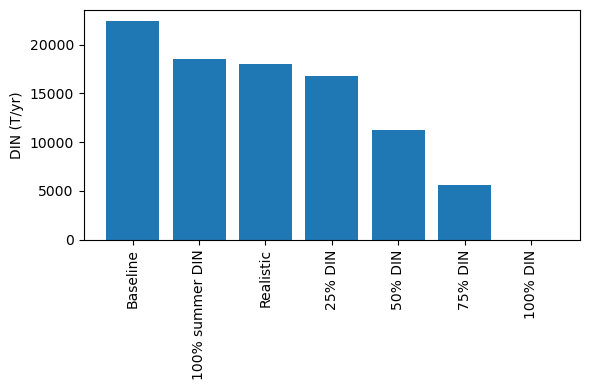

In [21]:
out_folder_figs = r"../output/plots"

plt.figure(figsize=(6, 4))
ax = plt.gca()
plt.bar(tot_of_df.index, tot_of_df['DIN'])
plt.ylabel('DIN (T/yr)')

# Rename x-axis labels
new_labels = ['Baseline', '100% summer DIN', 'Realistic', '25% DIN', '50% DIN', '75% DIN', '100% DIN']  # Provide your own labels
ax.set_xticklabels(new_labels)

# Rotate x-axis labels
ax.tick_params(axis='x', rotation=90)

plt.tight_layout()

fpath = os.path.join(out_folder_figs, 'barchart_total-annual-din_whole-of800-domain.png')
plt.savefig(fpath)

plt.show()